*Page and Latex Commands*
$\newcommand{\C}{\mathbb{C}}
\renewcommand{\R}{\mathbb{R}}
\renewcommand{\Z}{\mathbb{Z}}
\renewcommand{\N}{\mathbb{N}}
\newcommand{\Q}{\mathbb{Q}}
\newcommand{\mP}{\mathcal{P}}
\newcommand{\bp}{\begin{pmatrix}}
\newcommand{\ep}{\end{pmatrix}}
$

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sys

# Self Defined Functions
sys.path.append('..\lib')

from findiff import *
from opt import *
from krot import *

# Kantorovich-Rubenstein OT with Linear Solvers

**Problem Statement**

Provided initial mass distribution $\rho$ and final mass distribution $\sigma$ over a compact metric space $X$, along with the gradient of the cost function for each point in the space $\nabla c : x\in X \rightarrow \R^+$ find the function which minimizes the following integral equation

$$\begin{align*} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) \\
                \text{s.t.}\quad & |\nabla \phi(x)|\leq |\nabla c(x)|,\quad \forall x\in X \end{align*}$$


*In One Dimension*

The problem may be formulated as the following if $X$ is a one dimensional space.

$$\begin{align*} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) \\
                \text{s.t.}\quad & -|\nabla c(x)| \leq \nabla \phi(x)\leq |\nabla c(x)|,\quad \forall x\in X \end{align*}$$
                
*Discretized Problem*

If the problem is discretized for some points $x_i$ so that the mass at any location is atomic $\rho(x_i)=1$. Let the same hold for $\sigma$ and let $d(x_i)=\nabla c(x_i)$. Furthermore let $D_1$ be the discrete approximation of $\nabla$.

Then the problem may be formulated as the following.

$$\begin{align*} \min_\phi \quad & \sum_{i=1}^N \phi_i(\rho_i-\sigma_i) \\
                \text{s.t.}\quad & -d_i \leq D_+\phi_i \leq d_i,\quad \forall i=\{1,...,N\} \end{align*}$$

## Example 1: Single Transportation

In [2]:
n = 20*6 #Number of Interior Points
h=1/(n-1) #Step Size
x = np.linspace(0,1,n) #All 1D Examples may be expressed on the linesegment 0-1

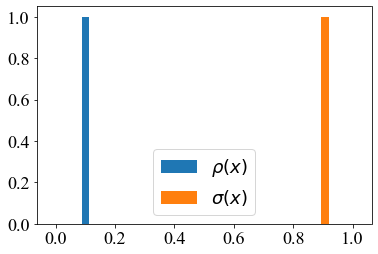

In [3]:
# Initial Distribution
rho= np.zeros(n)
rho[n//10] = 1
plt.bar(x,rho, width = 3*h, label='$\\rho(x)$')

# Final Distribution
sigma = np.zeros(n)
sigma[9*n // 10] = 1
plt.bar(x,sigma, width = 3*h, label='$\sigma(x)$')

plt.legend()
plt.show()

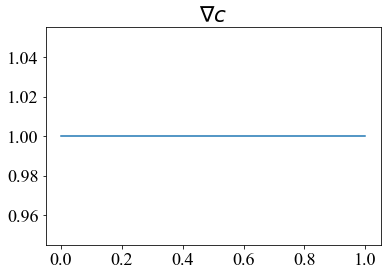

In [4]:
#Gradient C
Gc = np.ones(n)
#Gc[n//4:3*n//4]=2*np.ones(n//2)

plt.plot(x,Gc)
plt.title("$\\nabla c$")
plt.show()

The following method is implemented by `lin_krot`.

In [5]:
D = D1FE(n, bc = 'Neumann', matrix=True)

A = D/h
c = rho-sigma
b=Gc

phi = cp.Variable(n)
prob = cp.Problem(cp.Minimize(c.T@phi), [A@phi<=b,-A@phi<=b])
prob.solve()

-0.8067226889051241

----------------------
Optimization Problem


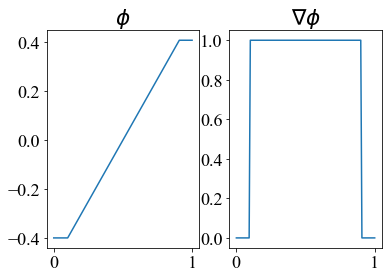

In [6]:
print("----------------------\nOptimization Problem")
plt.subplot(121)
plt.plot(x,phi.value)
plt.title("$\phi$")
plt.subplot(122)
plt.plot(x,A@phi.value)
plt.title("$\\nabla \phi$")
plt.show()

In [7]:
np.allclose(Gc[n//6:5*n//6], (A@phi.value)[n//6:5*n//6], 1e-3)

True

## Example 2 : Cost Regions

### 2.1 Single Cost Region

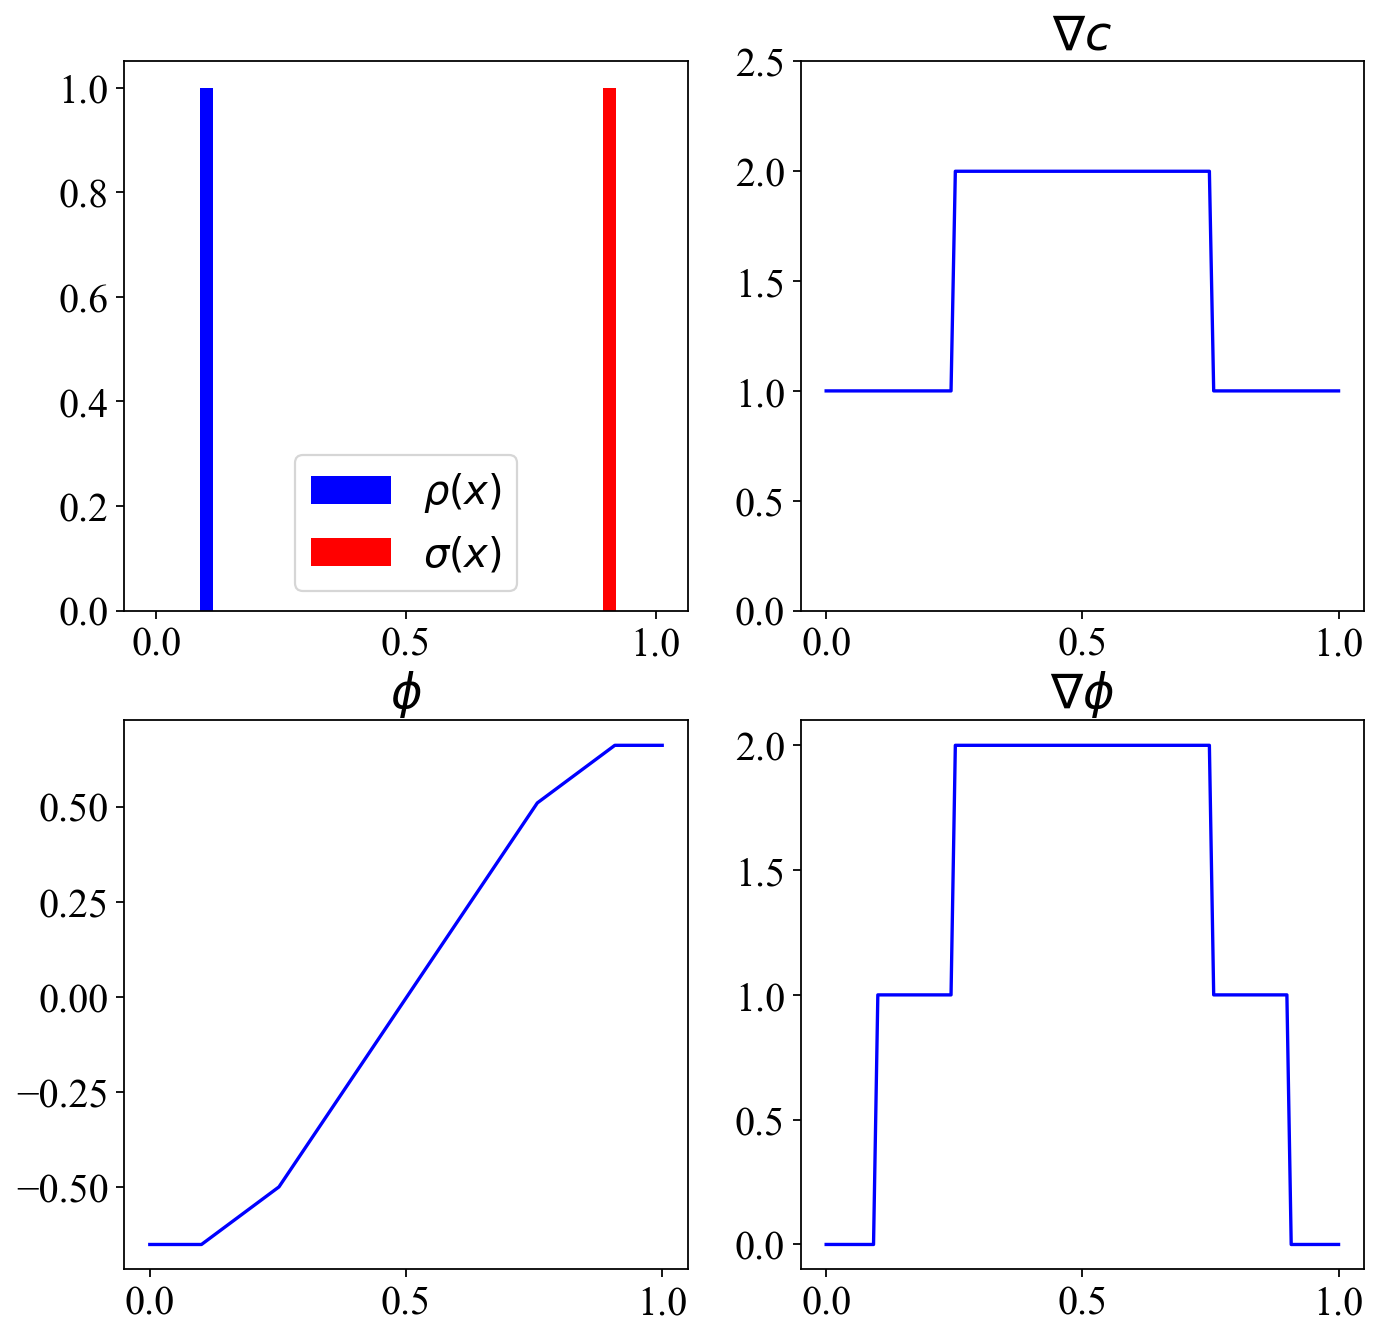

In [8]:
n = 20*6
h=1/(n-1)
x = np.linspace(0,1,n) 
# Initial Distribution
rho = np.zeros(n)
rho[n//10] = 1
# Final Distribution
sigma = np.zeros(n)
sigma[9*n // 10] = 1
#Gradient C
Gc = np.ones(n)
Gc[n//4:3*n//4]=2*np.ones(n//2)
#Solve
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

In [9]:
np.allclose(Gc[n//10:9*n//10], Gphi[n//10:9*n//10], 1e-3)

True

### 2.2 Multi Cost Regions

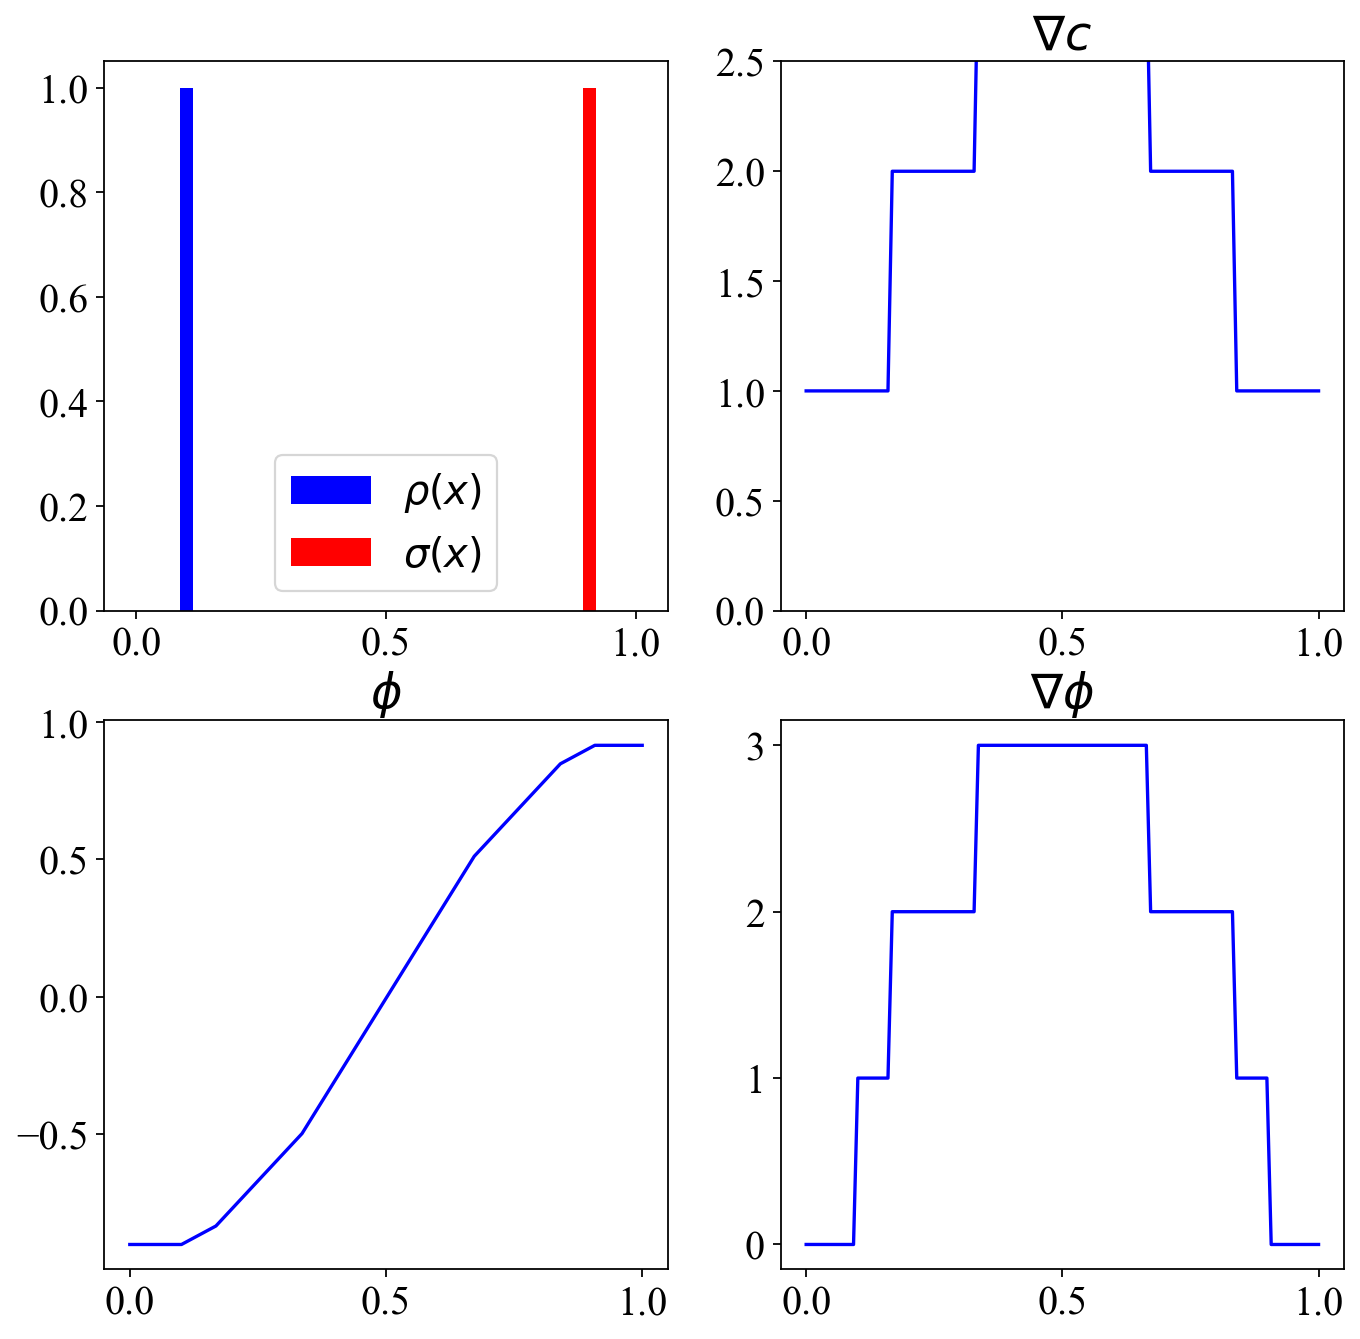

In [10]:
n = 20*6
h=1/(n-1)
x = np.linspace(0,1,n) 
# Initial Distribution
rho = np.zeros(n)
rho[n//10] = 1
# Final Distribution
sigma = np.zeros(n)
sigma[9*n // 10] = 1
#Gradient C
Gc = np.ones(n)
Gc[n//6:n//3]=2*np.ones(n//6)
Gc[n//3:2*n//3]= 3*np.ones(n//3)
Gc[2*n//3:5*n//6]=2*np.ones(n//6)
#Solve
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

In [11]:
np.allclose(Gc[n//6:5*n//6], Gphi[n//6:5*n//6], 1e-3)

True

### 2.3 High Variability Cost Region

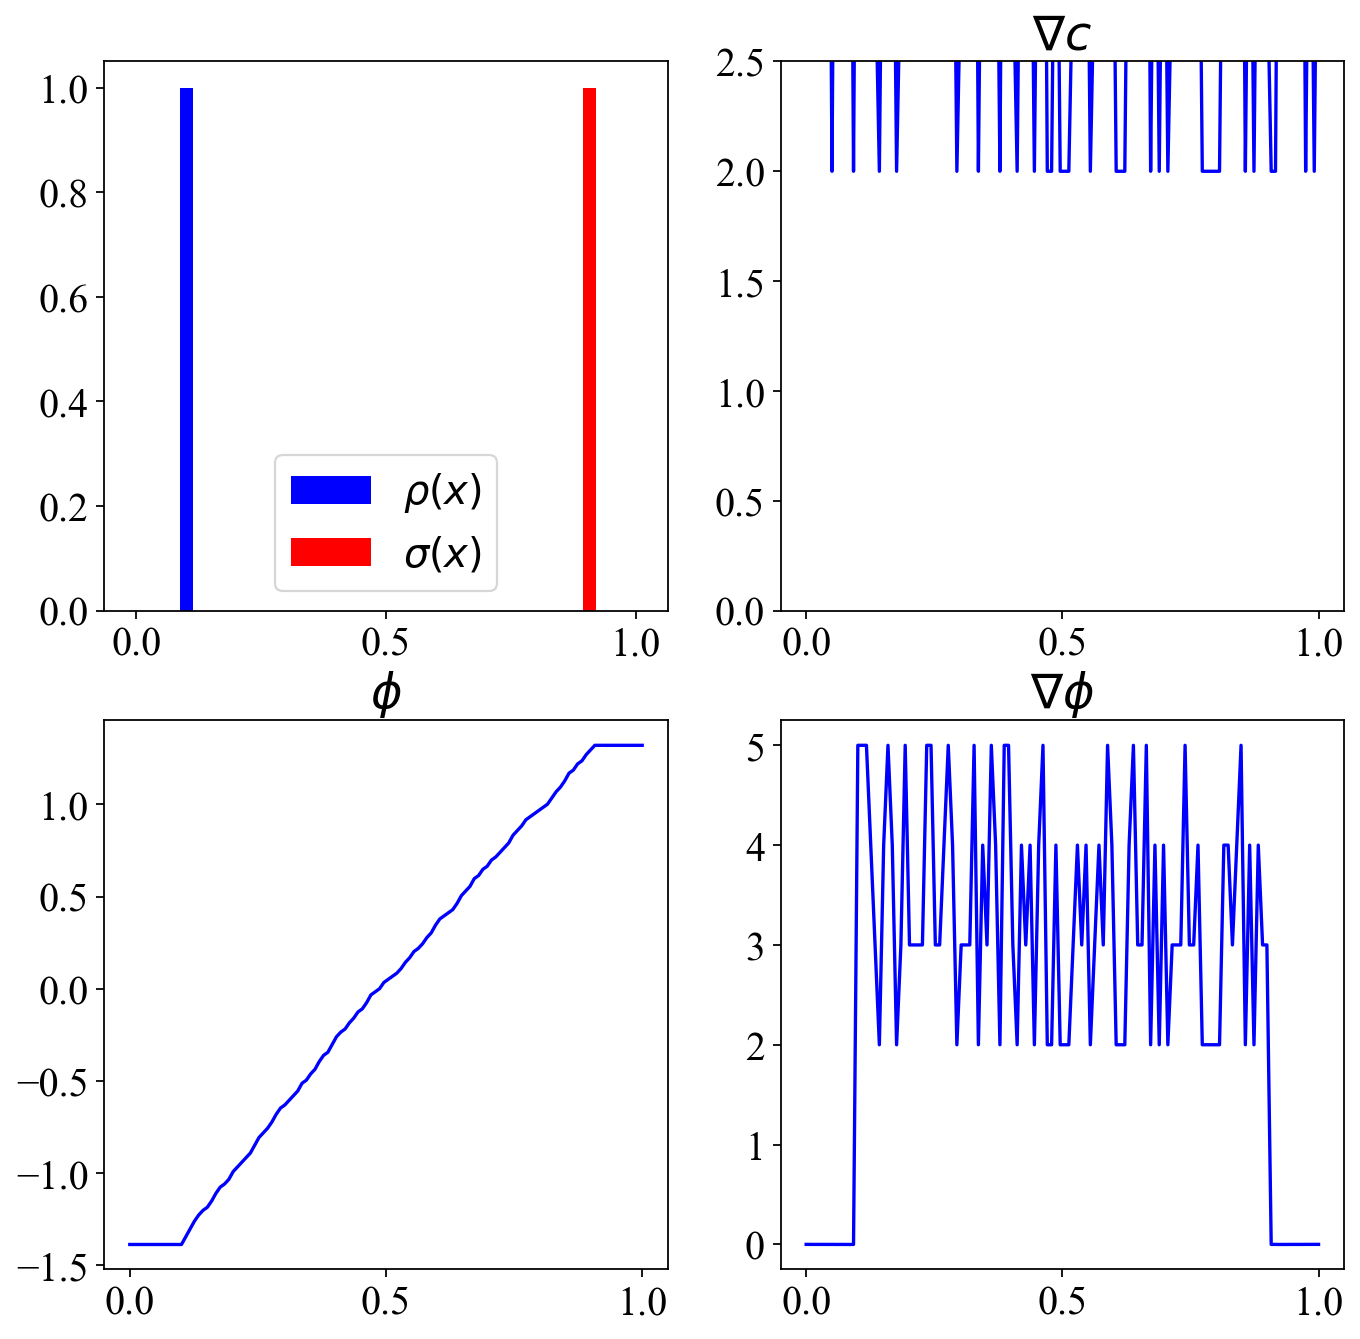

In [12]:
n = 20*6
h=1/(n-1)
x = np.linspace(0,1,n) 
# Initial Distribution
rho = np.zeros(n)
rho[n//10] = 1
# Final Distribution
sigma = np.zeros(n)
sigma[9*n // 10] = 1
#Gradient C
Gc = np.random.randint(2,6,n)
#Solve
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

In [13]:
np.allclose(Gc[n//10:9*n//10], Gphi[n//10:9*n//10], 1e-3)

True

## Example 3 : Multiple Masses

### 3.1 Left to Right

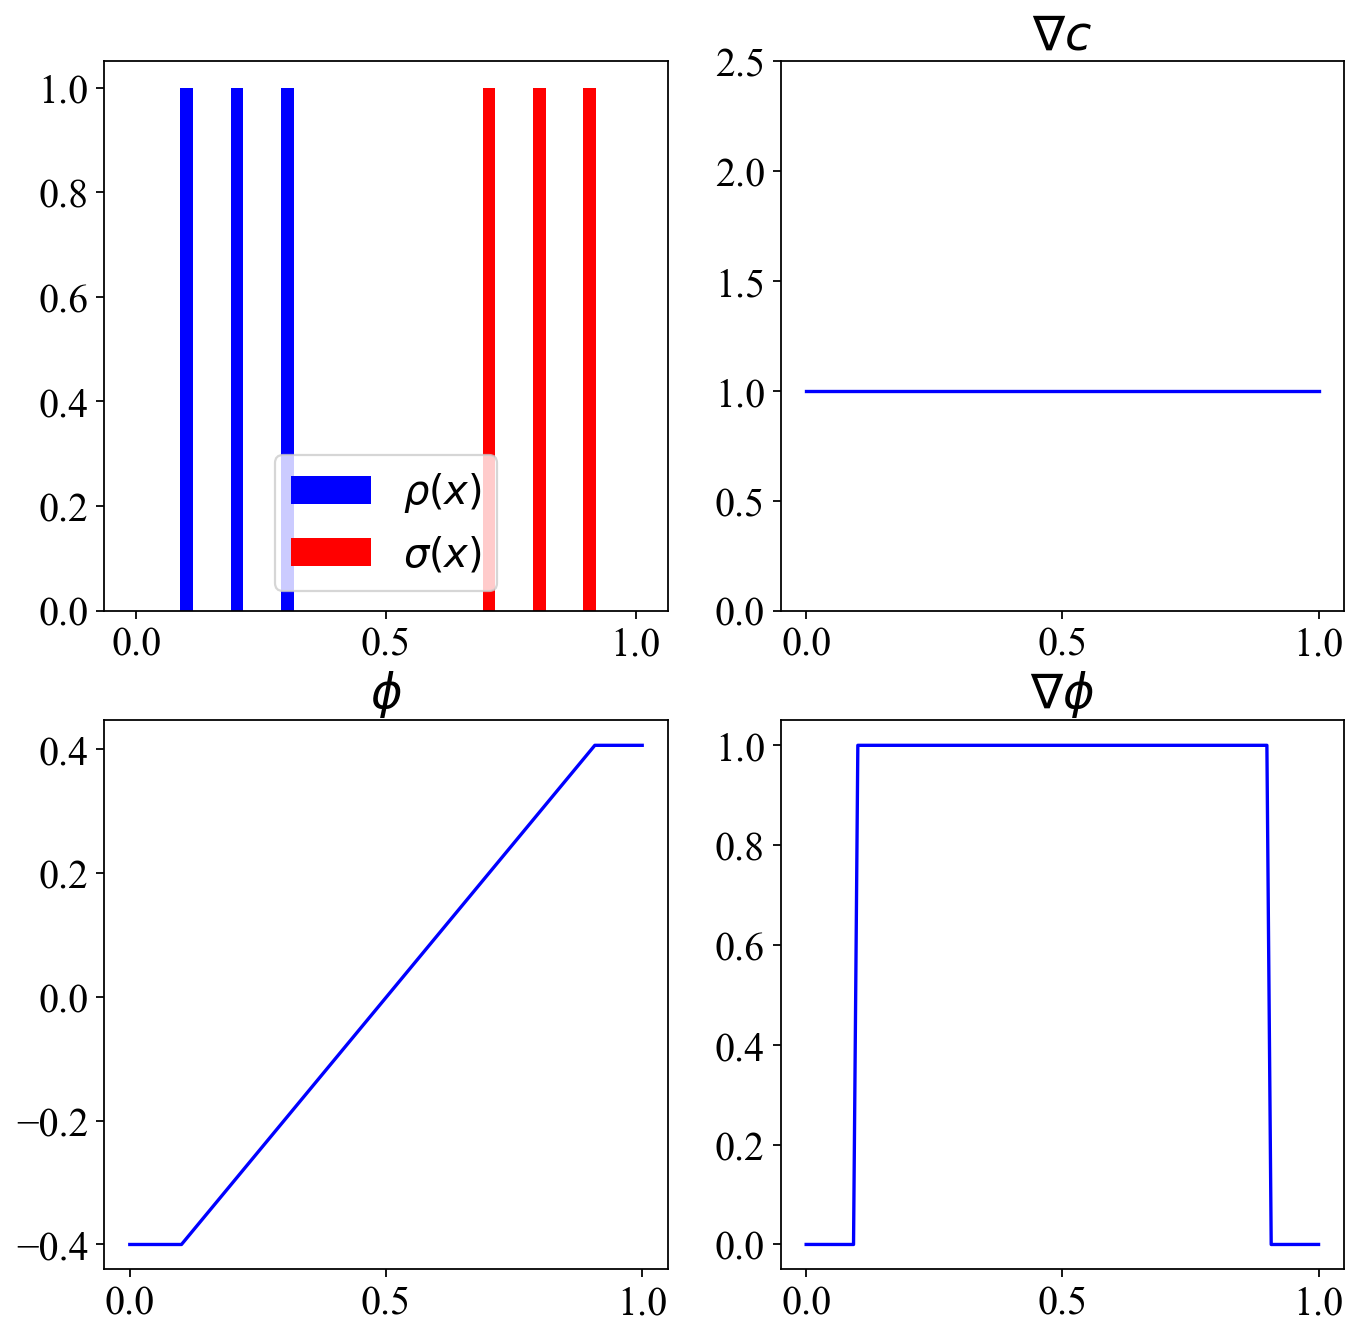

In [14]:
n = 20*6
h=1/(n-1)
x = np.linspace(0,1,n) 
# Initial Distribution
rho = np.zeros(n)
rho[n//10] = 1
rho[n//5] = 1
rho[3*n//10] = 1

# Final Distribution
sigma = np.zeros(n)
sigma[9*n // 10] = 1
sigma[4*n // 5] = 1
sigma[7*n // 10] = 1
#Gradient C
Gc = np.ones(n)
#Solve
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

In [15]:
np.allclose(Gc[n//10:9*n//10], Gphi[n//10:9*n//10], 1e-3)

True

### 3.2 Dispersed Left to Right

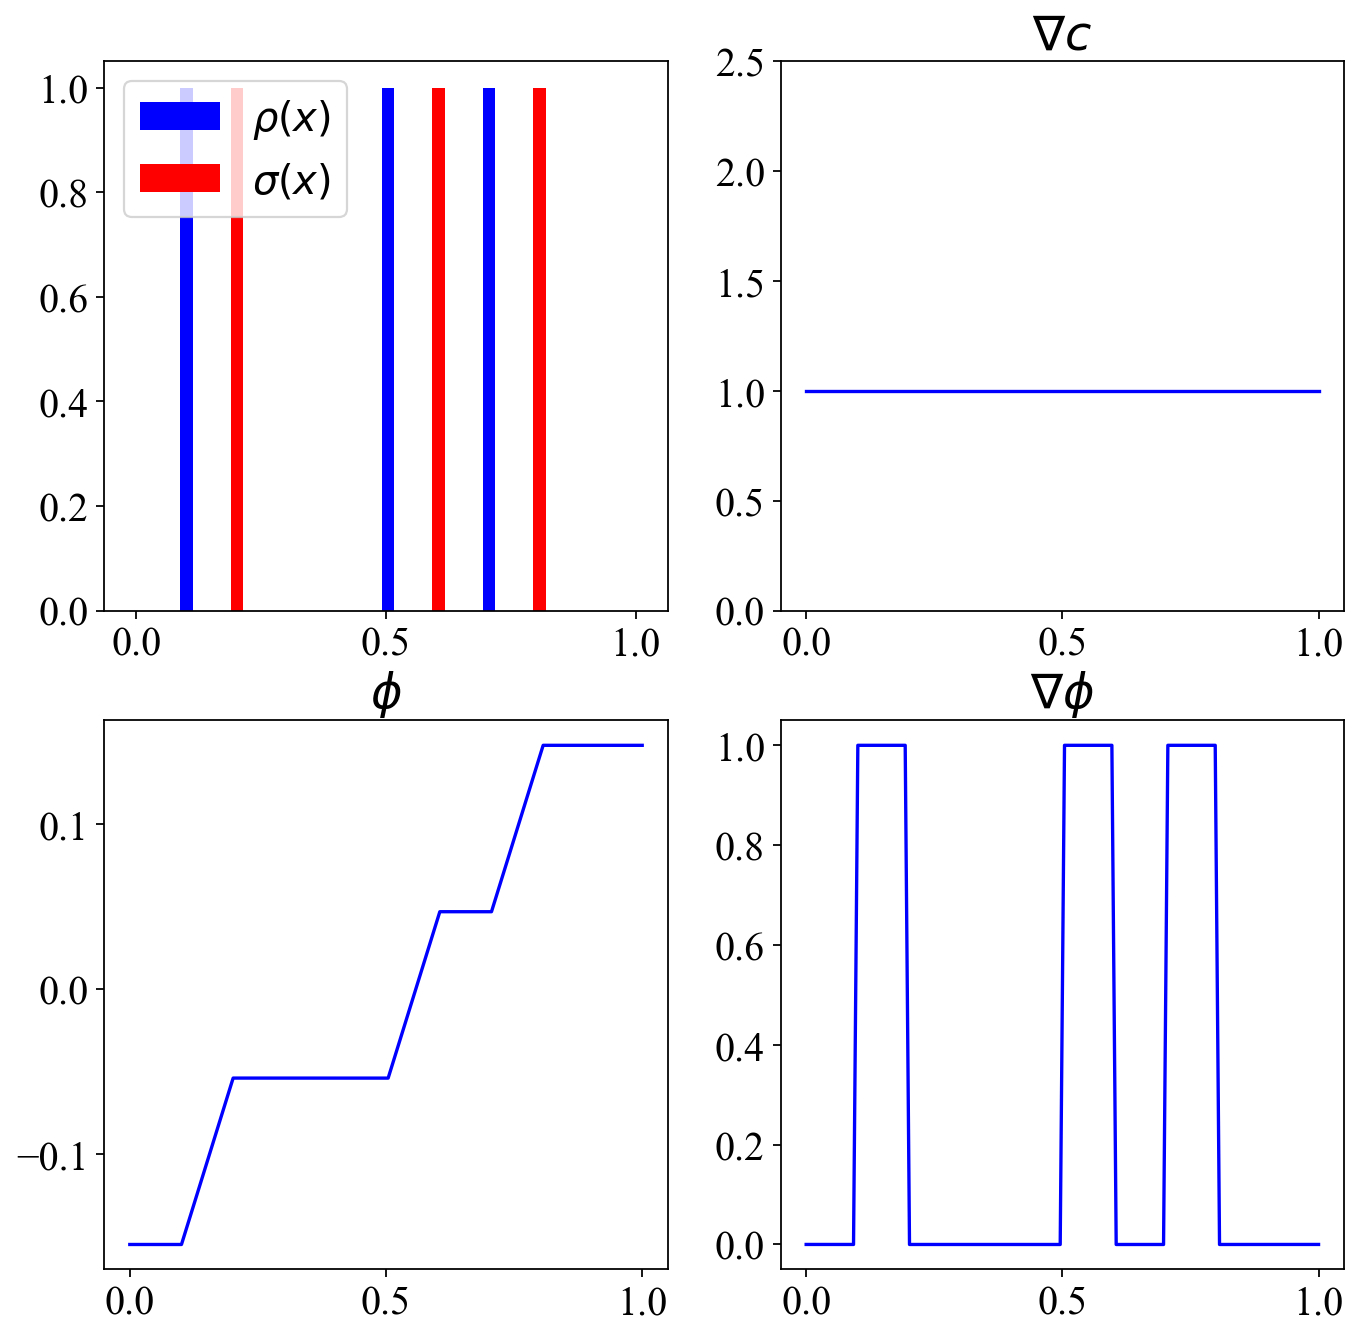

In [16]:
n = 20*6
h=1/(n-1)
x = np.linspace(0,1,n) 
# Initial Distribution
rho = np.zeros(n)
rho[n//10] = 1
rho[5*n//10] = 1
rho[7*n//10] = 1

# Final Distribution
sigma = np.zeros(n)
sigma[8*n // 10] = 1
sigma[6*n // 10] = 1
sigma[2*n // 10] = 1
#Gradient C
Gc = np.ones(n)
#Solve
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

### 3.3 Dispersed Variant Directions

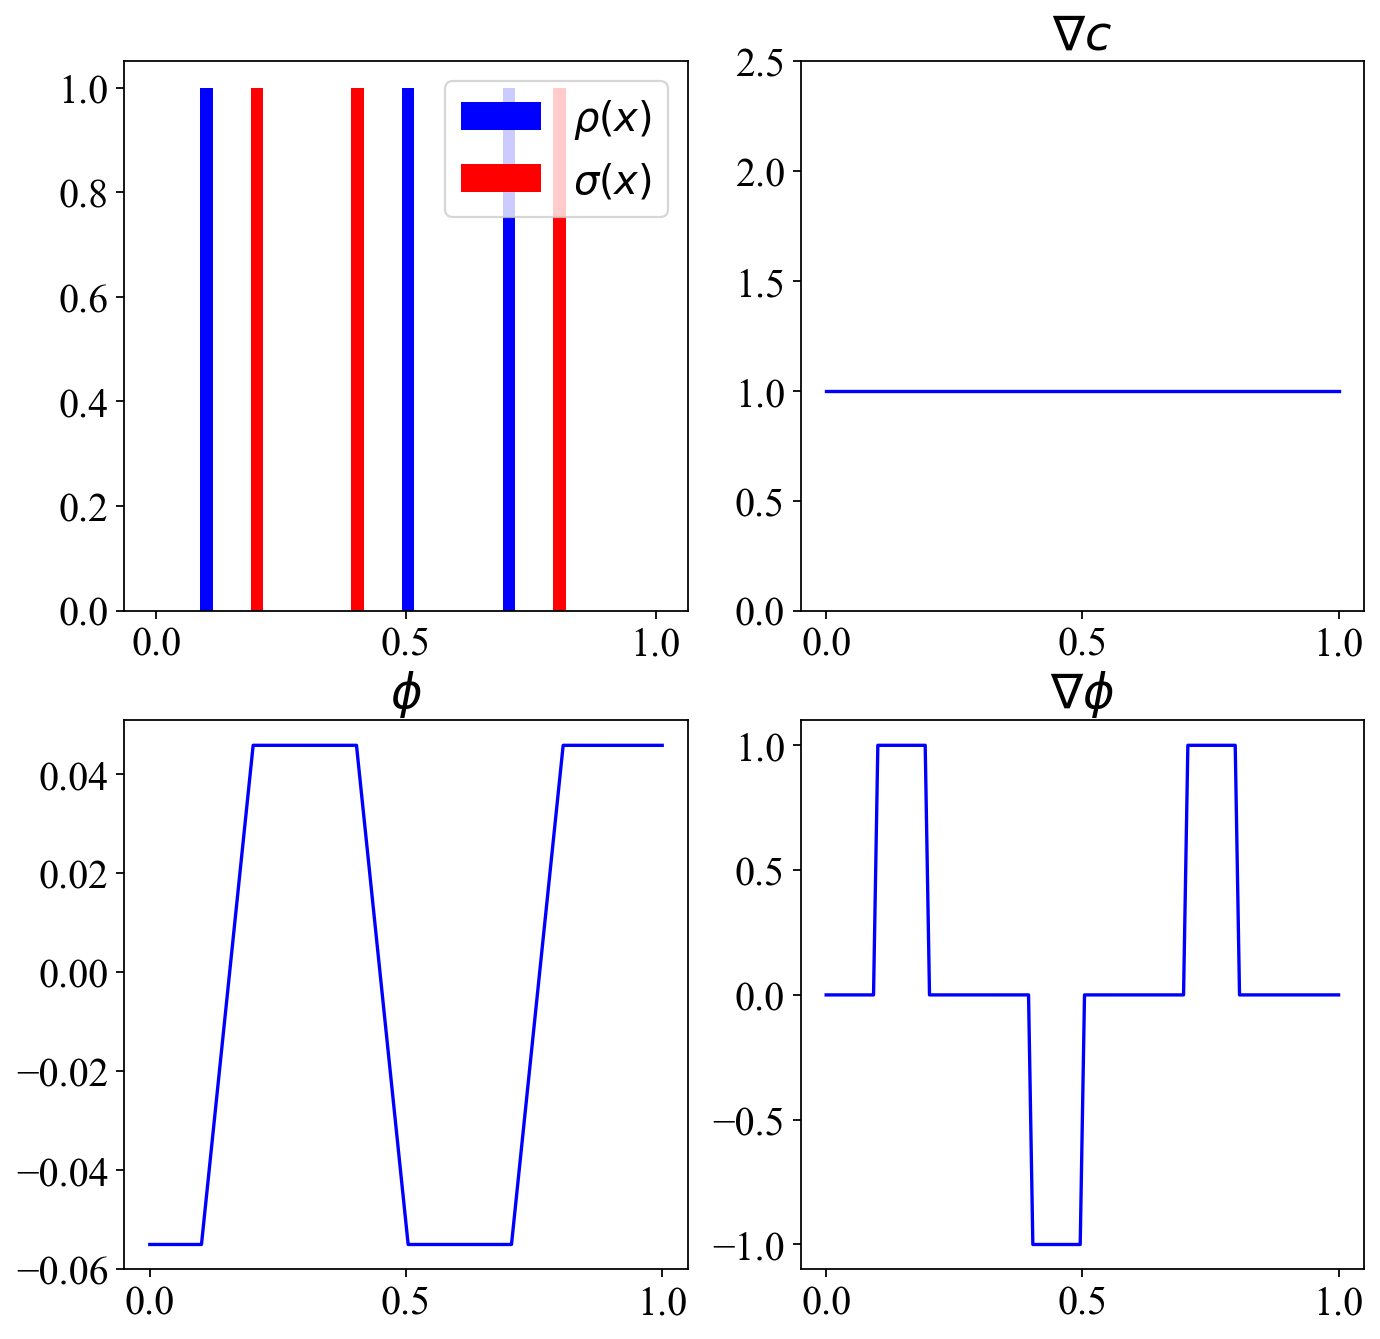

In [17]:
n = 20*6
h=1/(n-1)
x = np.linspace(0,1,n) 
# Initial Distribution
rho = np.zeros(n)
rho[n//10] = 1
rho[5*n//10] = 1
rho[7*n//10] = 1

# Final Distribution
sigma = np.zeros(n)
sigma[8*n // 10] = 1
sigma[4*n // 10] = 1
sigma[2*n // 10] = 1
#Gradient C
Gc = np.ones(n)
#Solve
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

## Example 4 : Variants of 2/3

### 4.1 : Dispersed Masses with Cost Regions Left to Right

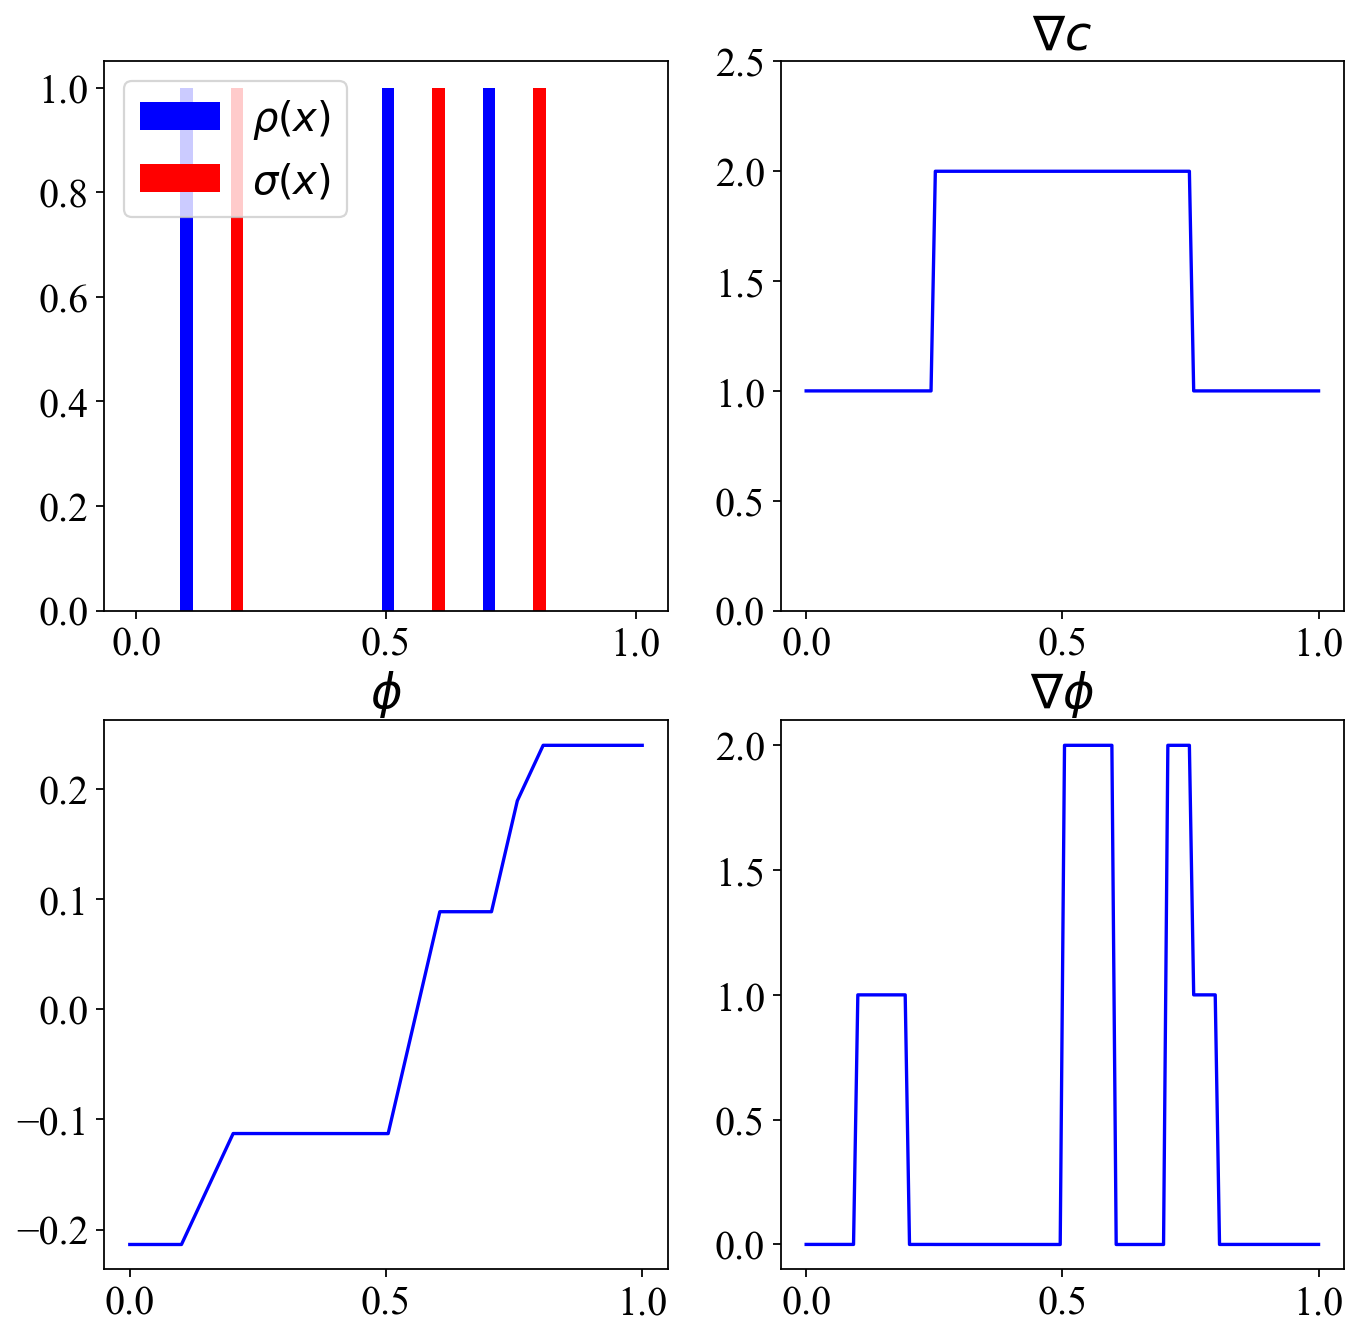

In [18]:
n = 20*6
h=1/(n-1)
x = np.linspace(0,1,n) 
# Initial Distribution
rho = np.zeros(n)
rho[n//10] = 1
rho[5*n//10] = 1
rho[7*n//10] = 1

# Final Distribution
sigma = np.zeros(n)
sigma[8*n // 10] = 1
sigma[6*n // 10] = 1
sigma[2*n // 10] = 1
#Gradient C
Gc = np.ones(n)
Gc[n//4:3*n//4]=2*np.ones(n//2)
#Solve
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

### 4.2 : Dispersed Masses with Cost Regions Varrying Directions

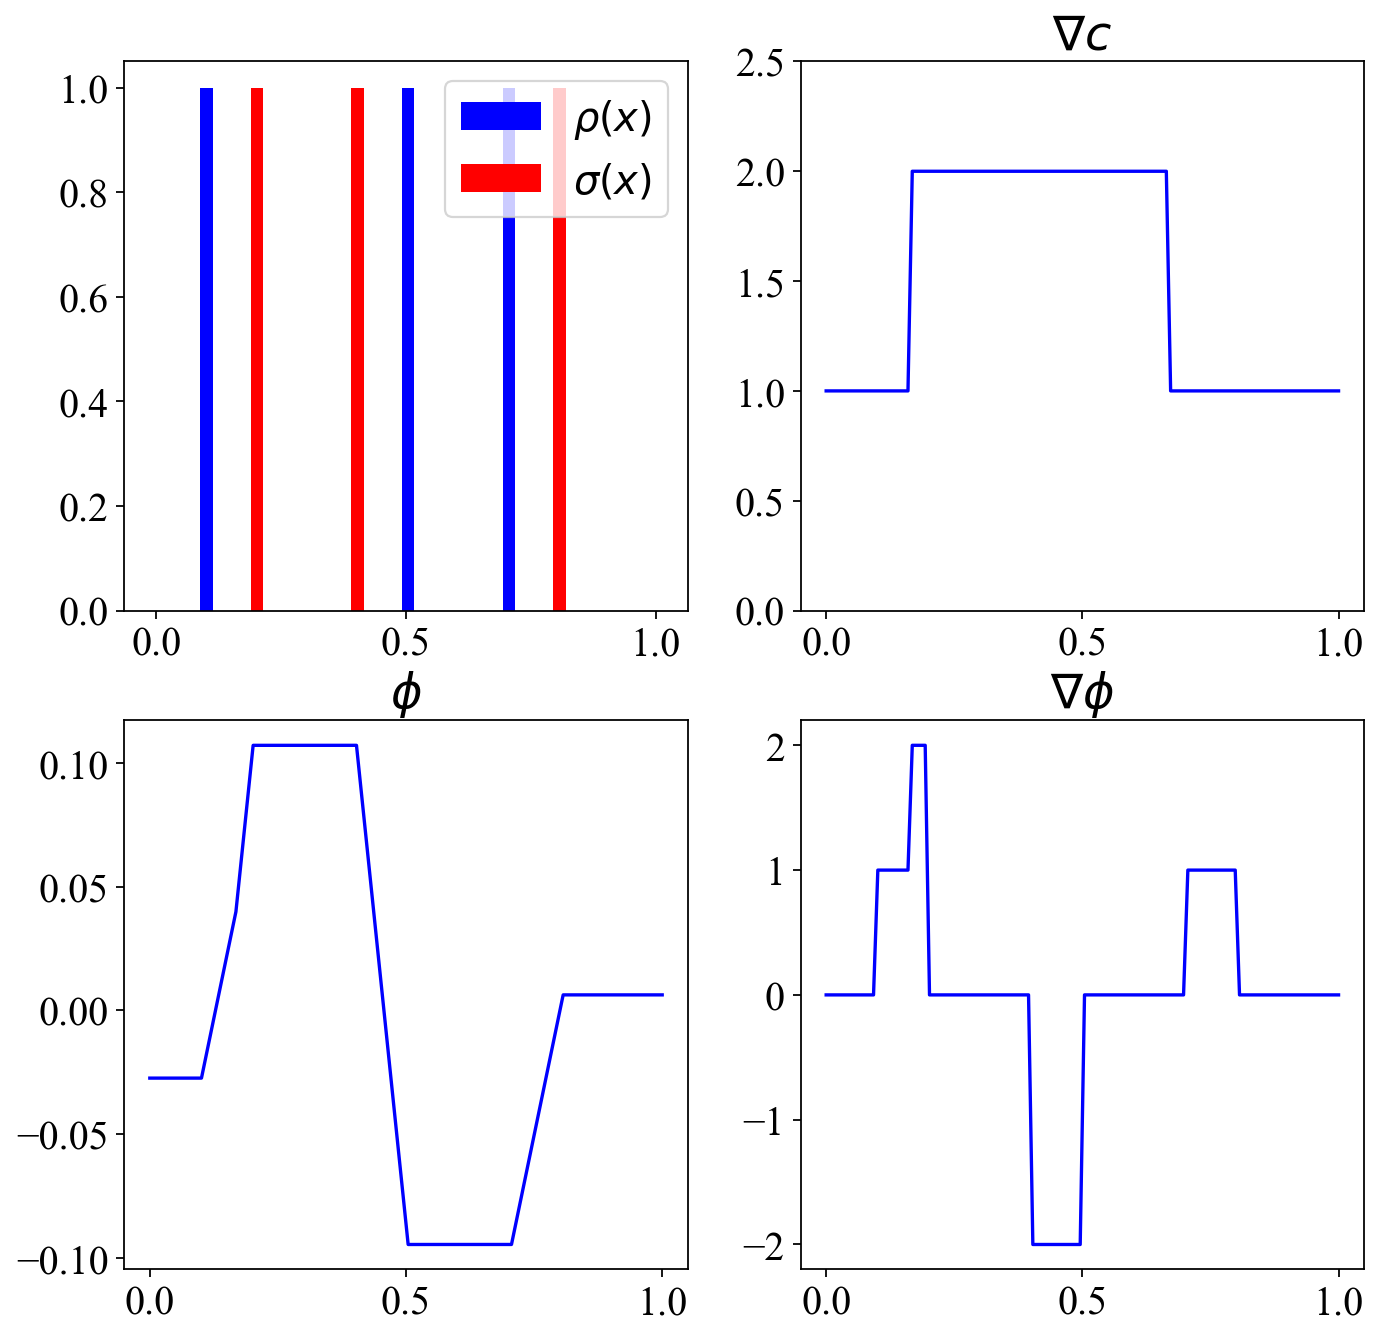

In [19]:
n = 20*6
h=1/(n-1)
x = np.linspace(0,1,n) 
# Initial Distribution
rho = np.zeros(n)
rho[n//10] = 1
rho[5*n//10] = 1
rho[7*n//10] = 1

# Final Distribution
sigma = np.zeros(n)
sigma[8*n // 10] = 1
sigma[4*n // 10] = 1
sigma[2*n // 10] = 1
#Gradient C
Gc = np.ones(n)
Gc[n//6:2*n//3]= 2*np.ones(n//2)
#Solve
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

## Example 5 : Non-Atomic Discretizations

### 5.1 Non-Atomic Masses Left to Right

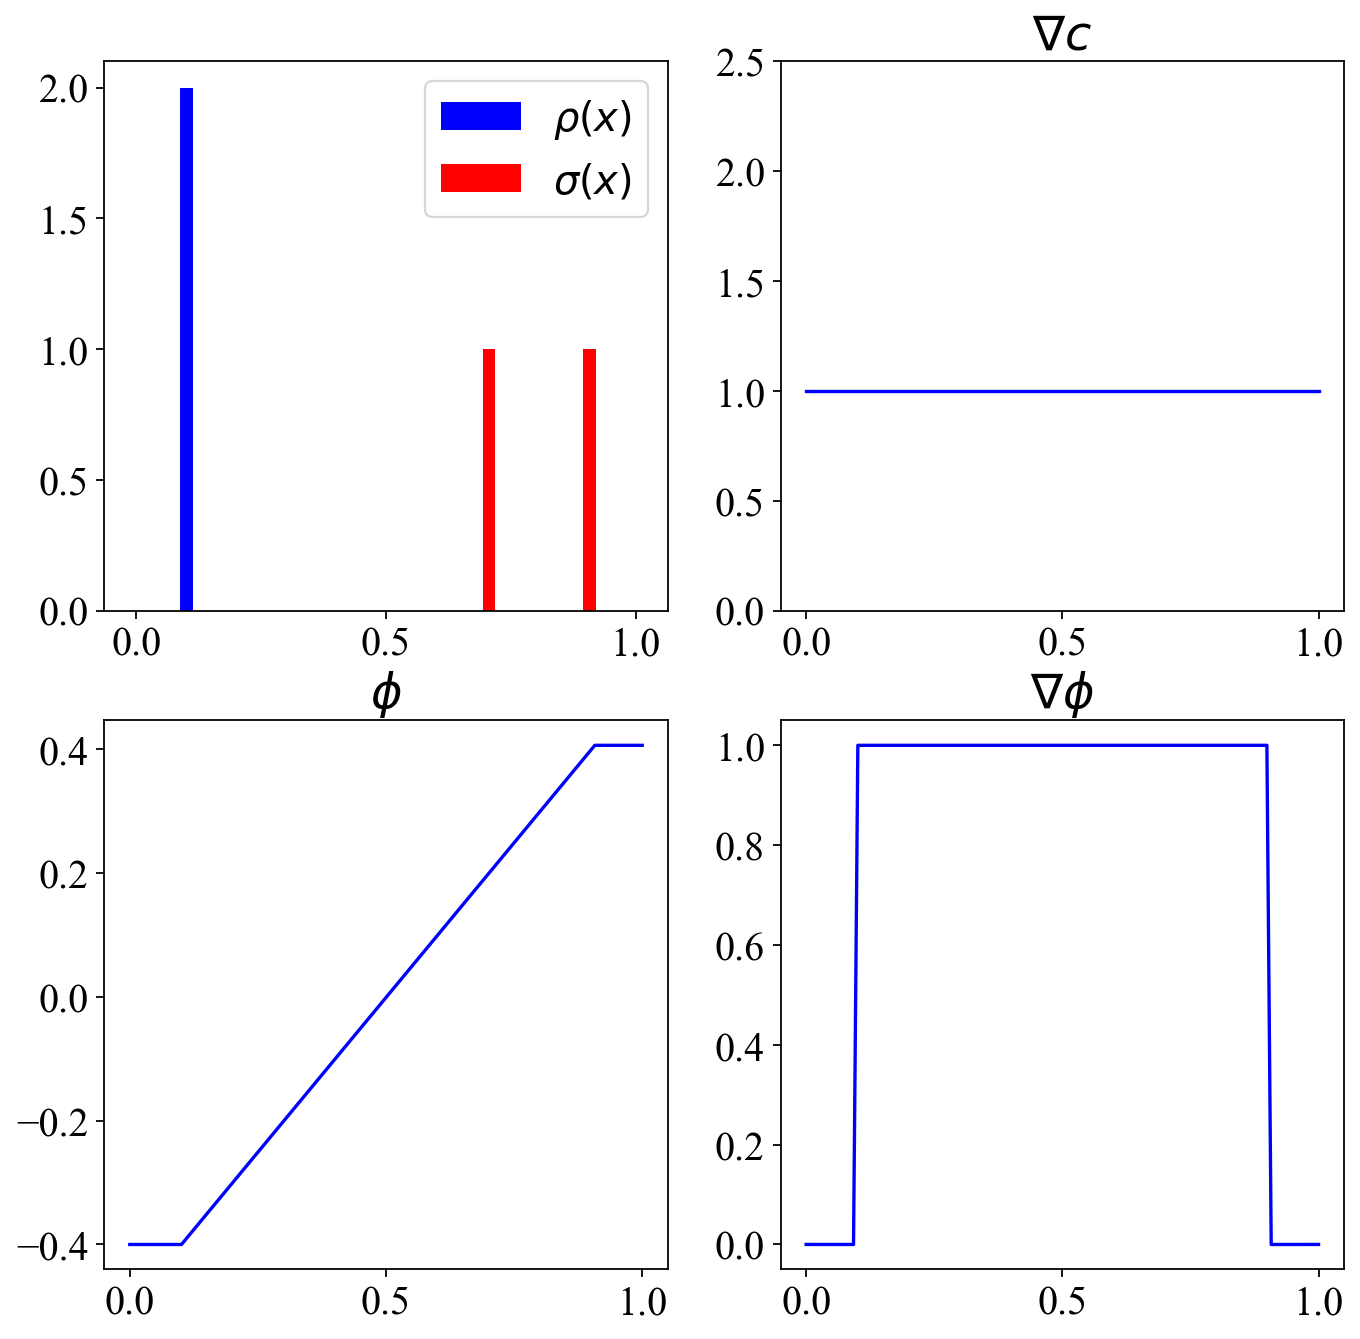

In [20]:
n = 20*6 #Number of Interior Points
x = np.linspace(0,1,n)

#RHS Function
rho,rho[n//10]=np.zeros(n),2
sigma,sigma[7*n//10],sigma[9*n//10] = np.zeros(n),1,1

#Gradient C
Gc = np.ones(n)
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

### 5.2 Non-Atomic Masses with Cost Regions Left to Right

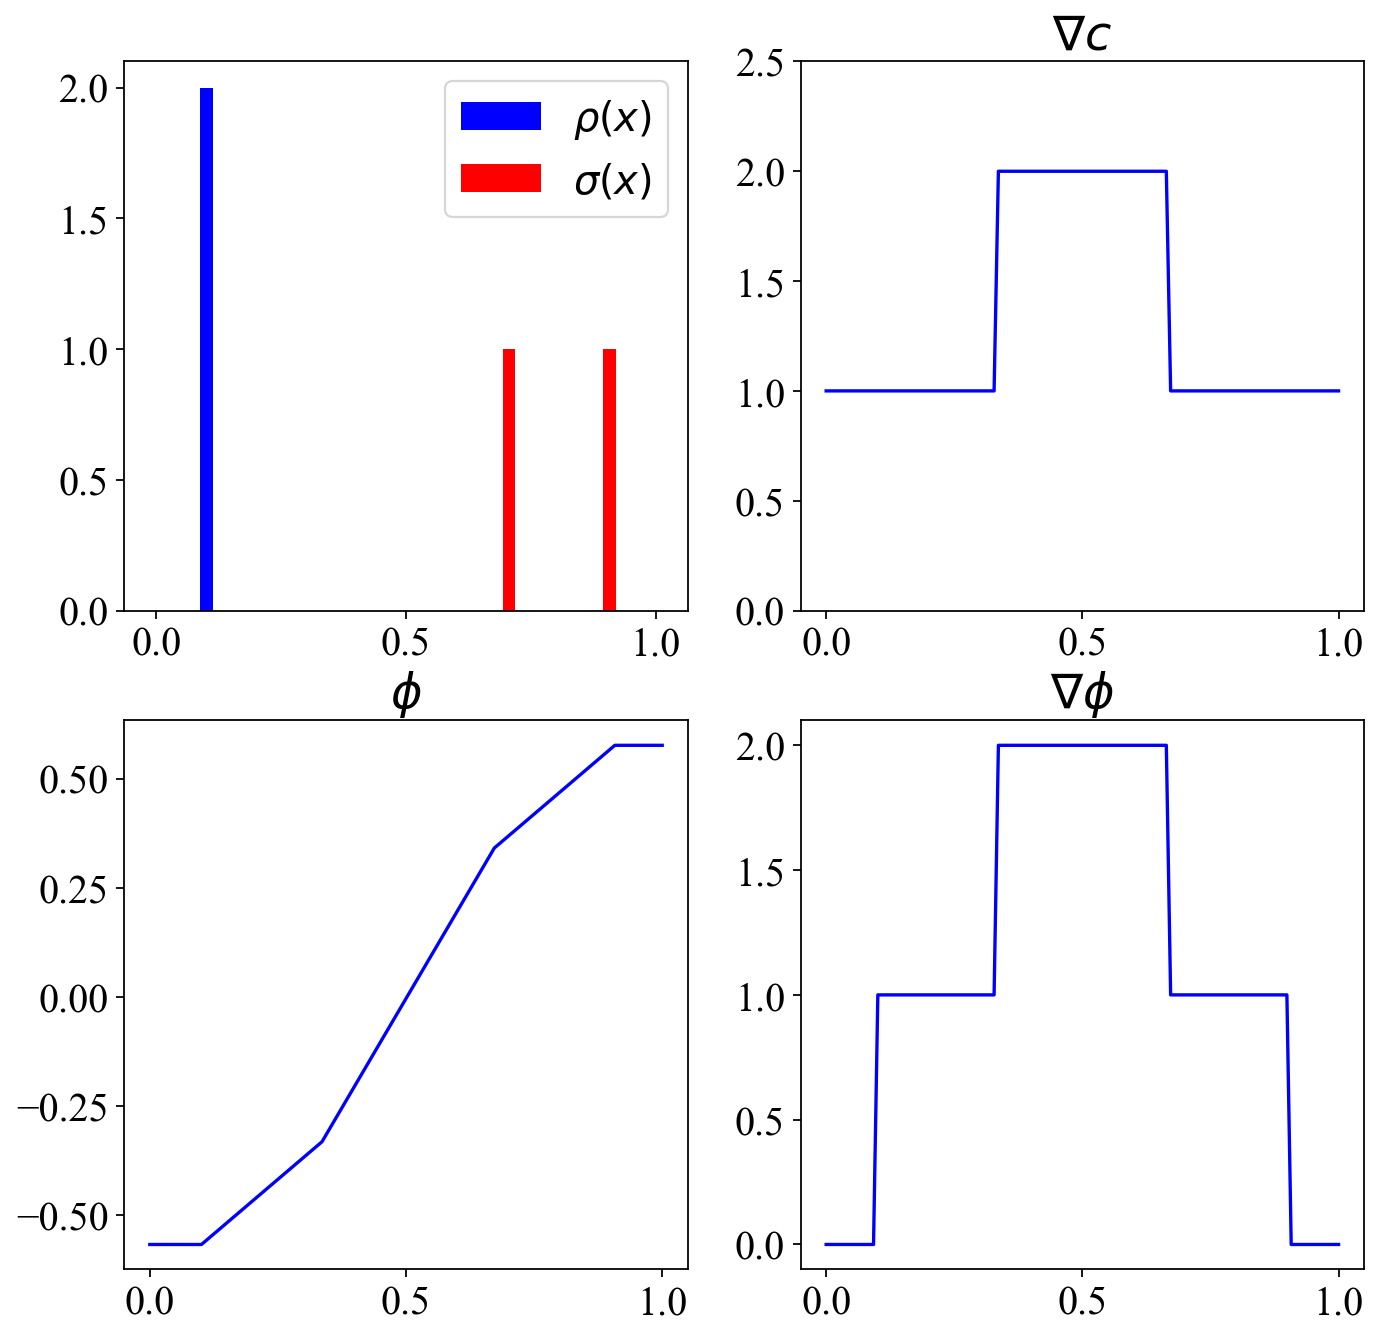

In [21]:
n = 20*6 #Number of Interior Points
x = np.linspace(0,1,n)

#RHS Function
rho,rho[n//10]=np.zeros(n),2
sigma,sigma[7*n//10],sigma[9*n//10] = np.zeros(n),1,1

#Gradient C
Gc = np.ones(n)
Gc[n//3:2*n//3]= 2*np.ones(n//3)
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

### 5.3 Non-Atomic Masses with Cost Regions and Separate Directionality

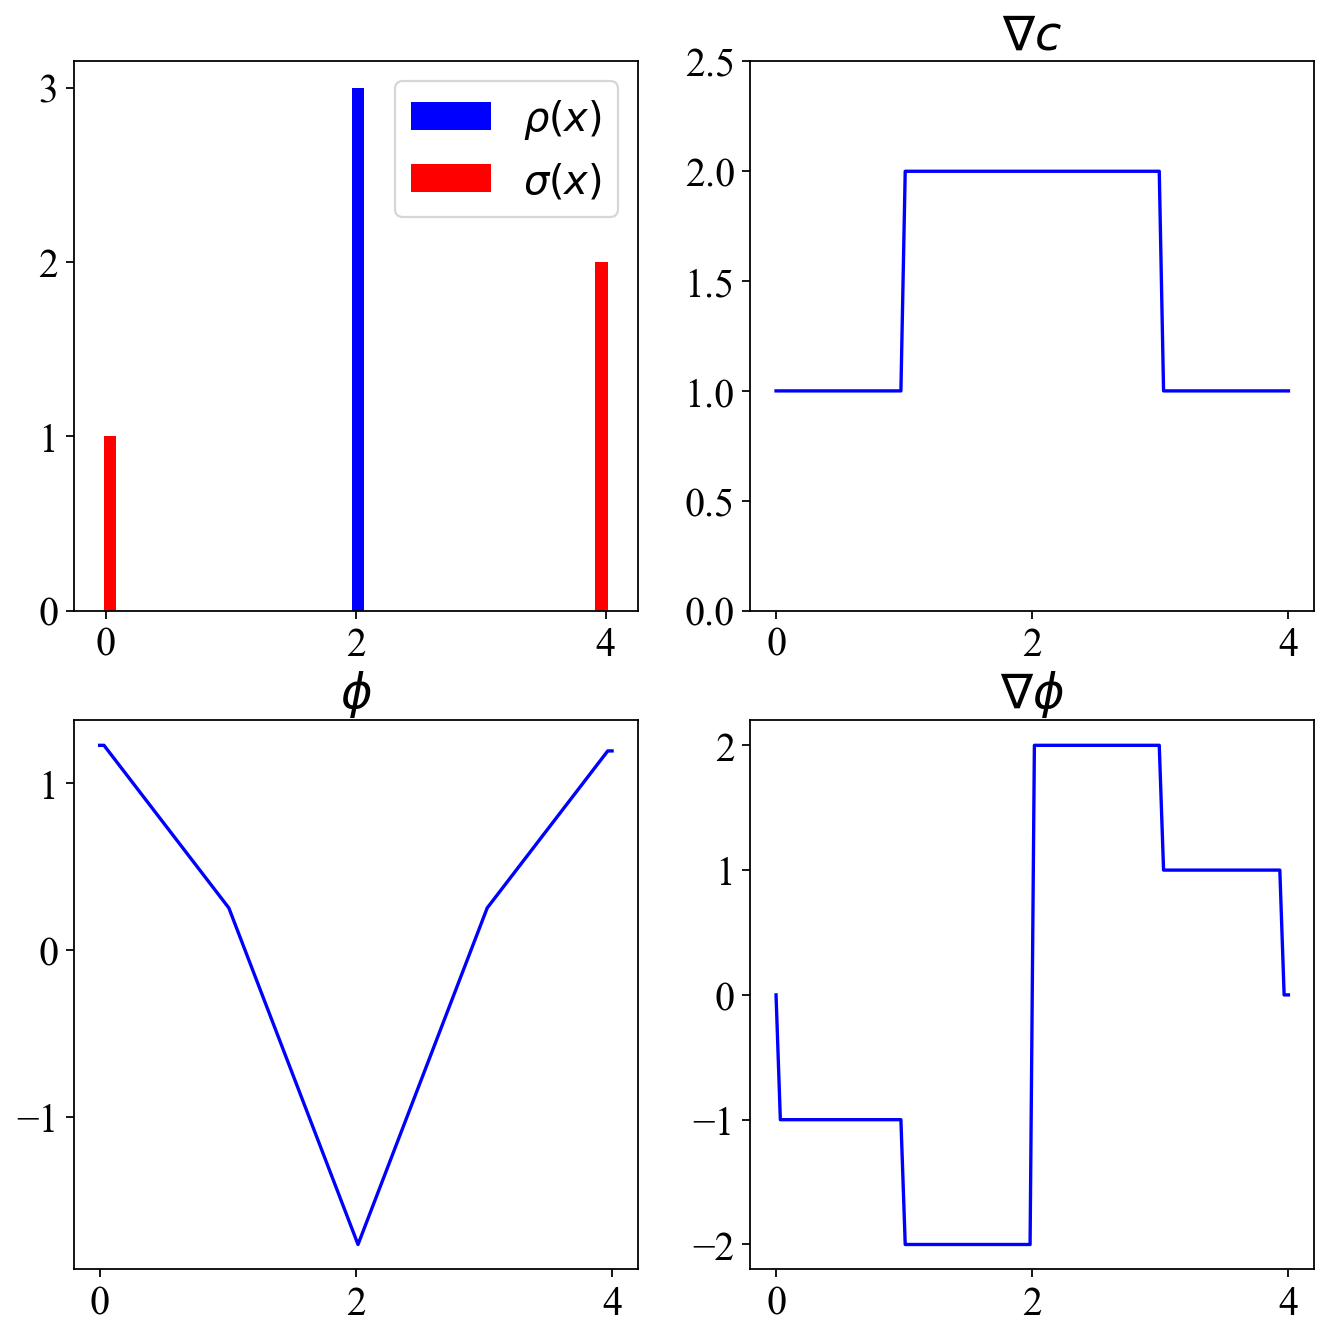

In [22]:
n = 20*6 #Number of Interior Points

h=1/(n-1)
x = np.linspace(0,4,n)

#RHS Function
rho,rho[n//2]=np.zeros(n),3
sigma,sigma[1],sigma[n-2] = np.zeros(n),1,2

#Gradient C
Gc = np.ones(n)
Gc[n//4:3*n//4]=2*np.ones(3*n//4-n//4)
phi,Gphi = lin_krot(x,rho, sigma, Gc, vis=True)

## Discussion

**Missing Information**

All of the transportation network information is contained in $\phi(x)$. The optimal network can be found by formulating the primal problem in terms of the dual problem.  However this reformulation requires knowledge of the distributed cost function $c(p,q)$. In the case that only features of the distributed cost function are known i.e. $\nabla c$, the dual step is missing information about the optimal network.

* How much mass is transferred along in the flow $\nabla \phi$?

* When has a particular mass reached its destination?

For example, were you to govern the flow of a set of objects using (3.1), your objects will transfer entirely to the final node.

*Note:* In the $\lambda$ problem changes in the masses or cost in the flow act are seen as impulses on the flow.